In [2]:

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import numpy as np
import pandas as pd
import pickle

# Update the font size to 14
font = {
    "size": 14,
}
mpl.rc("font", **font)

/home/156/cn1951/tmp/ipykernel_152146/3577318360.py:106: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="Normalised Grokking Gap")


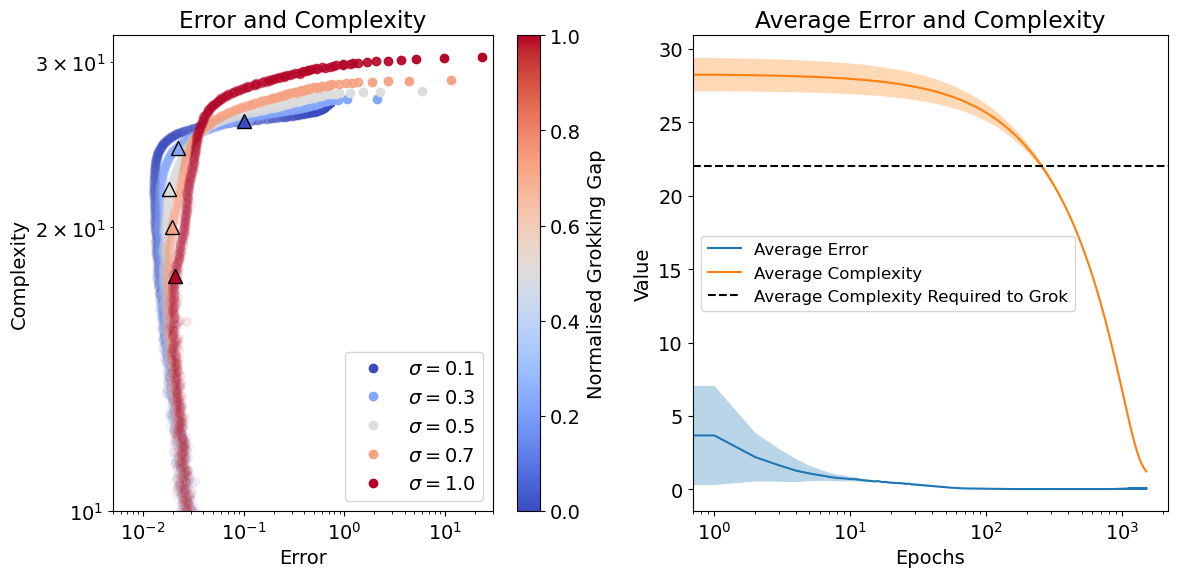

In [3]:
# Re-loading the data for all seeds and variances
variances_with_complete_data = ['0.1', '0.3', '0.5', '0.7', '1.0']
seeds = ['0', '1', '2']

# Initialize empty dictionaries to hold the data
datafit_dict = {}
complexity_dict = {}
grokking_gap_dict = {}
training_accuracy_dict = {}
validation_accuracy_dict = {}

# Loop through each variance and each seed to load the data
for var in variances_with_complete_data:
    for seed in seeds:
        file_path = f'experiments/complexity_error_bnn_grokking/results_{var}_1500_seed{seed}.pkl'
        with open(file_path, 'rb') as f:
            loaded_data = pickle.load(f)
        
        # Store the loaded data in the dictionaries, indexed by (variance, seed)
        datafit_dict[(var, seed)] = loaded_data['datafit']
        complexity_dict[(var, seed)] = loaded_data['complexity']
        grokking_gap_dict[(var, seed)] = loaded_data['grokking_gap']
        training_accuracy_dict[(var, seed)] = loaded_data['training_accuracy']
        validation_accuracy_dict[(var, seed)] = loaded_data['validation_accuracy']

# Initialize lists to store averaged values and grokking points
avg_datafit_list = []
avg_complexity_list = []
avg_grokking_gap_list = []
grokking_points_datafit = []
grokking_points_complexity = []

threshold = 0.95
epochs = 1500

# Loop through each variance to compute averaged values and grokking points
for var in variances_with_complete_data:
    # Initialize temporary lists to hold data for averaging
    temp_datafit = []
    temp_complexity = []
    temp_grokking_gap = []
    temp_complexities_to_grok = []
    temp_datafit_to_grok = []
    
    for seed in seeds:
        # Append the data for this seed to the temporary lists
        temp_datafit.append(datafit_dict[(var, seed)])
        temp_complexity.append(complexity_dict[(var, seed)])
        temp_grokking_gap.append(grokking_gap_dict[(var, seed)])
        
        # Compute the grokking point for this seed
        training_accuracy = training_accuracy_dict[(var, seed)]
        validation_accuracy = validation_accuracy_dict[(var, seed)]
        complexity = complexity_dict[(var, seed)]
        datafit = datafit_dict[(var, seed)]
        
        training_indices_above_95 = np.where(training_accuracy > threshold)[0]
        training_accuracy_above_95 = training_indices_above_95[0] if training_indices_above_95.size > 0 else epochs
        validation_indices_above_95 = np.where(validation_accuracy > threshold)[0]
        validation_accuracy_above_95 = validation_indices_above_95[0] if validation_indices_above_95.size > 0 else epochs
        
        if validation_accuracy_above_95 != epochs:
            temp_complexities_to_grok.append(complexity[validation_accuracy_above_95])
            temp_datafit_to_grok.append(datafit[validation_accuracy_above_95])
    
    # Compute the average values and grokking points across seeds, and append to the main lists
    avg_datafit_list.append(np.mean(temp_datafit, axis=0))
    avg_complexity_list.append(np.mean(temp_complexity, axis=0))
    avg_grokking_gap_list.append(np.mean(temp_grokking_gap))
    if temp_complexities_to_grok:
        grokking_points_datafit.append(np.mean(temp_datafit_to_grok))
        grokking_points_complexity.append(np.mean(temp_complexities_to_grok))

# Create the plots using the same logic as the original code
plt.figure(figsize=(12, 6))

# First subplot for Error vs Complexity
plt.subplot(1, 2, 1)
cmap = cm.coolwarm
normalized_grokking_gap = [(gap - min(avg_grokking_gap_list)) / (max(avg_grokking_gap_list) - min(avg_grokking_gap_list)) for gap in avg_grokking_gap_list]

# Increase the size of the triangles
triangle_size = 15
for i, (datafit, complexity, var) in enumerate(zip(avg_datafit_list, avg_complexity_list, variances_with_complete_data)):
    num_points = len(datafit)
    for j in range(num_points):
        alpha_max = 1.0
        alpha_min = 0.05
        k = -np.log(0.1 / 0.9) / 100
        alpha_val = alpha_min + (alpha_max - alpha_min) * np.exp(-k * j)
        plt.plot(datafit[j], complexity[j], 'o', label=f"$\sigma = {var}$" if j == 0 else "", color=cmap(normalized_grokking_gap[i]), linewidth=3.5, alpha=alpha_val)
    
    # Plot the grokking point
    plt.plot(grokking_points_datafit[i], grokking_points_complexity[i], "^", color="black", markersize=triangle_size, alpha=1.0, markerfacecolor=cmap(normalized_grokking_gap[i]), markeredgecolor="black", zorder=100000)

plt.xlabel("Error")
plt.ylabel("Complexity")
plt.xscale("log")
plt.yscale("log")
plt.ylim([10, 3.2e1])
plt.xlim([5e-3, 30])
plt.title("Error and Complexity")
plt.legend()

# Link the colorbar to the normalized colormap
sm = cm.ScalarMappable(cmap=cmap)
sm.set_array([])
plt.colorbar(sm, label="Normalised Grokking Gap")

# Second subplot for Average Error and Complexity
plt.subplot(1, 2, 2)
avg_datafit = np.mean(avg_datafit_list, axis=0)
avg_complexity = np.mean(avg_complexity_list, axis=0)
std_datafit = np.std(avg_datafit_list, axis=0)
std_complexity = np.std(avg_complexity_list, axis=0)

plt.plot(avg_datafit, label="Average Error")
plt.plot(avg_complexity, label="Average Complexity")
plt.fill_between(range(len(avg_datafit)), avg_datafit - std_datafit, avg_datafit + std_datafit, alpha=0.3)
plt.fill_between(range(len(avg_complexity)), avg_complexity - std_complexity, avg_complexity + std_complexity, alpha=0.3)

# Average grokking point
avg_grok_complexity = np.mean(grokking_points_complexity)
plt.axhline(y=avg_grok_complexity, color="black", linestyle="--", label="Average Complexity Required to Grok")

plt.xlabel("Epochs")
plt.xscale("log")
plt.ylabel("Value")
plt.title("Average Error and Complexity")
plt.legend(fontsize=12)

plt.tight_layout()
plt.savefig("experiments/complexity_error_bnn_grokking/averaged_runs.pdf", dpi=300, bbox_inches="tight")
plt.show()